<a href="https://colab.research.google.com/github/maxashoka3/Aerial-Vechile-Classification/blob/main/Aerial_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Function to convert ANNOTATION TO THE YOLO ANNOTATION

In [ ]:

import os
from os import walk, getcwd
from PIL import Image
import cv2
import re


classes = ["AEROPLANE","DRONE","HELICOPTER"]

def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    
    return (x,y,w,h)
    
    
""" Configure Paths"""  
def changing_label(label):
#mypath = "Labels/AEROPLANE/"   # mypath is the input path of our image txt file folder.firstly we are working on 1st object
    #mypath = "Labels/AEROPLANE/"
    mypath = f"Labels/{label}/"
    #outpath = "Labels\output_AEROPLANE/"  # where to store the final output txt file
    outpath = "Hello/"  # where to store the final output txt file

    #cls = "AEROPLANE"   # on this object we want to train. Remember always train one class at a time. So I have trained first on it and now I am commenting this to work on other class
    cls = f"{label}"   # on this object we want to train
    if cls not in classes:
        exit(0)
    cls_id = classes.index(cls)

    wd = getcwd()
    list_file = open('%s/%s_list.txt'%(wd, cls), 'w')

    """ Get input text file list """
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        txt_name_list.extend(filenames)
        break
    print(txt_name_list)



    """ Process """
    for txt_name in txt_name_list:


        """ Open input text files """
        txt_path = mypath + txt_name
        print("Input:" + txt_path)
        txt_file = open(txt_path, "r")
        lines = txt_file.read()

        lines = lines.strip()  
        while '  ' in lines:
            lines = lines.replace('  ', ' ')

        lines = lines.split('\n')   #for ubuntu, use "\r\n" instead of "\n"





        """ Open output text files """
        txt_outpath = outpath + txt_name
        print("Output:" + txt_outpath)
        txt_outfile = open(txt_outpath, "w")


        """ Convert the data to YOLO format """
        ct = 0
        for line in lines:
            #print('lenth of line is: ')
            #print(len(line))
            #print('\n')
            if(len(line) >= 2):
                ct = ct + 1
                #print(line + "\n")
                print(line)
                elems = line.split(' ')
                print("first")
                print(elems)
                print("finshed first")
                xmin = elems[0]
                xmax = elems[2]
                ymin = elems[1]
                ymax = elems[3]
                #
                img_path = str('%s/Images/%s/%s.png'%(wd, cls, os.path.splitext(txt_name)[0]))
                
                im=Image.open(img_path)
                w= int(im.size[0])
                h= int(im.size[1])
                
                print(w, h)
                b = (float(xmin), float(xmax), float(ymin), float(ymax))
                bb = convert((w,h), b)
                print(bb)
                txt_outfile.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

        """ Save those images with bb into list"""
        if(ct != 0):
            list_file.write('%s/Images/%s/%s.png\n'%(wd, cls, os.path.splitext(txt_name)[0]))

    list_file.close()          

In [ ]:
labels = ['AEROPLANE','DRONE','HELICOPTER']

for each in classes:
    changing_label(each)

### Preparing for the yaml format...

In [ ]:
# Pip install (recommended)

!pip install ultralytics
     

In [ ]:

## importing required libraries
import os
import shutil
import random

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_path_img = "./yolo_data/images/train/"
train_path_label = "./yolo_data/labels/train/"
val_path_img = "./yolo_data/images/val/"
val_path_label = "./yolo_data/labels/val/"
test_path = "./yolo_data/test"

In [ ]:
'''
Split the dataset into train and test and creates the train.txt and test.tx with
the respective path of the images in each folder
'''

def train_test_split(path,neg_path=None, split = 0.2):
    print("------ PROCESS STARTED -------")


    files = list(set([name[:-4] for name in os.listdir(path)])) ## removing duplicate names i.e. counting only number of images
    

    print (f"--- This folder has a total number of {len(files)} images---")
    random.seed(42)
    random.shuffle(files)

    test_size = int(len(files) * split)
    train_size = len(files) - test_size

    ## creating required directories

    os.makedirs(train_path_img, exist_ok = True)
    os.makedirs(train_path_label, exist_ok = True)
    os.makedirs(val_path_img, exist_ok = True)
    os.makedirs(val_path_label, exist_ok = True)

    
    ### ----------- copying images to train folder
    for filex in tqdm(files[:train_size]):
      if filex == 'classes':
          continue
      shutil.copy2(path + filex + '.png',f"{train_path_img}/" + filex + '.png' )
      shutil.copy2(path + filex + '.txt', f"{train_path_label}/" + filex + '.txt')
        
    

    print(f"------ Training data created with 80% split {len(files[:train_size])} images -------")
    
    if neg_path:
        neg_images = list(set([name[:-4] for name in os.listdir(neg_path)])) ## removing duplicate names i.e. counting only number of images
        for filex in tqdm(neg_images):
            shutil.copy2(neg_path+filex+ ".png", f"{train_path_img}/" + filex + '.png')
            
        print(f"------ Total  {len(neg_images)} negative images added to the training data -------")
    
        print(f"------ TOTAL Training data created with {len(files[:train_size]) + len(neg_images)} images -------")
    


    ### copytin images to validation folder
    for filex in tqdm(files[train_size:]):
      if filex == 'classes':
          continue
      # print("running")
      shutil.copy2(path + filex + '.png', f"{val_path_img}/" + filex + '.png' )
      shutil.copy2(path + filex + '.txt', f"{val_path_label}/" + filex + '.txt')

    print(f"------ Testing data created with a total of {len(files[train_size:])} images ----------")
    
    print("------ TASK COMPLETED -------")

## spliting the data into train-test and creating train.txt and test.txt files
# train_test_split('/content/drive/MyDrive/custom_notebooks/yolo_data/')

### for label_tag
train_test_split('/content/drive/MyDrive/yolov8/data/') ### without negative images
# train_test_split('./data/','./negative_images/') ### if you want to feed negative images
     

------ PROCESS STARTED -------
--- This folder has a total number of 149 images---


  0%|          | 0/120 [00:00<?, ?it/s]

------ Training data created with 80% split 120 images -------


  0%|          | 0/29 [00:00<?, ?it/s]

------ Testing data created with a total of 29 images ----------
------ TASK COMPLETED -------


### For detecting

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.23 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.6/78.2 GB disk)


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/yolov8/dataset.yaml epochs=10 imgsz=640 batch=8 project=/content/drive/MyDrive/yolov8/training_results name=football 
  

Ultralytics YOLOv8.0.22 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/yolov8/dataset.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, cache=False, device=, workers=8, project=/content/drive/MyDrive/yolov8/training_results, name=football, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, o

In [ ]:

!yolo task=detect mode=predict model=/content/drive/MyDrive/yolov8/training_results/football3/weights/best.pt conf=0.55 source=/content/drive/MyDrive/yolov8/test_images 
     


Ultralytics YOLOv8.0.22 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
image 1/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_001524.png: 512x640 15.3ms
image 2/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_003481.png: 512x640 1 Helicopter, 14.2ms
image 3/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_003629.png: 512x640 1 Helicopter, 14.2ms
image 4/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_004076.png: 512x640 14.2ms
image 5/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_005218.png: 512x640 14.2ms
image 6/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000167.png: 512x640 14.2ms
image 7/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000168.png: 512x640 14.2ms
image 8/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000169.png: 512x640 14.2ms
image 9/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000170.png: 512x640 14.2ms
image 10/18 /co

In [ ]:

!cp -r /content/runs/detect/predict /content/drive/MyDrive/yolov8/output

cp: cannot stat '/content/runs/detect/predict': No such file or directory


### For classification....

In [ ]:
!yolo task= classify mode=train model=yolov8x.pt data=/content/drive/MyDrive/yolov8/dataset.yaml epochs=10 imgsz=640 batch=8 project=/content/drive/MyDrive/yolov8/training_results name=Drone

100% 131M/131M [00:01<00:00, 120MB/s]

WARNING ⚠️ 'task=classify' conflicts with detect model yolov8x.pt. Inheriting 'task=detect' from yolov8x.pt and ignoring 'task=classify'.
Ultralytics YOLOv8.0.22 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/yolov8/dataset.yaml, epochs=10, patience=50, batch=8, imgsz=640, save=True, cache=False, device=, workers=8, project=/content/drive/MyDrive/yolov8/training_results, name=Drone, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_co

In [ ]:

!yolo task=classify mode=predict model=/content/drive/MyDrive/yolov8/training_results/Drone2/weights/best.pt conf=0.55 source=/content/drive/MyDrive/yolov8/test_images 
     


WARNING ⚠️ 'task=classify' conflicts with detect model /content/drive/MyDrive/yolov8/training_results/Drone2/weights/best.pt. Inheriting 'task=detect' from /content/drive/MyDrive/yolov8/training_results/Drone2/weights/best.pt and ignoring 'task=classify'.
Ultralytics YOLOv8.0.22 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
image 1/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_001524.png: 512x640 77.7ms
image 2/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_003481.png: 512x640 62.0ms
image 3/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_003629.png: 512x640 45.7ms
image 4/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_004076.png: 512x640 44.3ms
image 5/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_005218.png: 512x640 44.6ms
image 6/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000167.png: 512x640 43.5ms
image 7/18 /content/drive/MyDrive/yolov8/tes

### From the python

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO()  # build a new model from scratch
model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/drive/MyDrive/yolov8/dataset.yaml", epochs=100, imgsz=640)

In [ ]:
!cp -r /content/runs/ /content/drive/MyDrive/yolov8/output

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO()  # build a new model from scratch
model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="/content/drive/MyDrive/yolov8/dataset.yaml", epochs=100, imgsz=640)

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load an official model
model = YOLO("/content/runs/detect/train/weights/best.pt")  # load a custom model

# Validate the model
results = model.val() 

  0%|          | 0.00/6.23M [00:00<?, ?B/s]


Ultralytics YOLOv8.0.22 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/yolo_data/labels/val.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]
                   all         29         29      0.995          1      0.995      0.977
             Aeroplane         29         11          1          1      0.995      0.973
                 Drone         29         11          1          1      0.995      0.987
            Helicopter         29          7      0.986          1      0.995      0.972
Speed: 0.2ms pre-process, 63.6ms inference, 0.0ms loss, 1.0ms post-process per image


In [ ]:


# Load a model
model = YOLO("yolov8n.pt")  # load an official model
model = YOLO("/content/runs/detect/train/weights/best.pt")  # load a custom model

# Predict with the mo
model("/content/drive/MyDrive/yolov8/test_images/AIRPLANE_001524.png") 

Ultralytics YOLOv8.0.22 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs
image 1/1 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_001524.png: 512x640 103.6ms
Speed: 0.5ms pre-process, 103.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([0, 6])
 dtype: torch.float32
  + tensor([], device='cuda:0', size=(0, 6))]

### YOLO without proir model

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO()  # build a new model from scratch
#model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)

# Train the model
model.train(data="/content/drive/MyDrive/yolov8/dataset.yaml", epochs=50, imgsz=640)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [ ]:
!yolo task= detect mode = val model = '/content/runs/detect/train/weights/best.pt' data=/content/drive/MyDrive/yolov8/dataset.yaml 

Ultralytics YOLOv8.0.23 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/yolo_data/labels/val.cache... 29 images, 0 backgrounds, 0 corrupt: 100% 29/29 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:01<00:00,  1.67it/s]
                   all         29         29      0.873      0.933      0.948      0.773
             Aeroplane         29         15      0.711        0.8      0.853      0.564
                 Drone         29          8      0.964          1      0.995      0.838
            Helicopter         29          6      0.943          1      0.995      0.918
Speed: 0.2ms pre-process, 7.5ms inference, 0.0ms loss, 1.8ms post-process per image


In [ ]:

!yolo task = detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/yolov8/test_images save=True
     


Ultralytics YOLOv8.0.23 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
image 1/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_001524.png: 512x640 14.2ms
image 2/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_003481.png: 512x640 9.0ms
image 3/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_003629.png: 512x640 8.7ms
image 4/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_004076.png: 512x640 8.7ms
image 5/18 /content/drive/MyDrive/yolov8/test_images/AIRPLANE_005218.png: 512x640 8.8ms
image 6/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000167.png: 512x640 8.7ms
image 7/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000168.png: 512x640 19.6ms
image 8/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000169.png: 512x640 9.8ms
image 9/18 /content/drive/MyDrive/yolov8/test_images/DRONE_000170.png: 512x640 9.0ms
image 10/18 /content/drive/MyDrive/yolov8/test_ima

In [ ]:




!yolo task = detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.55 source=/content/john-mcarthur-X_MOr6oa4-k-unsplash.jpg save=True
     


Ultralytics YOLOv8.0.23 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs
image 1/1 /content/john-mcarthur-X_MOr6oa4-k-unsplash.jpg: 448x640 15.1ms
Speed: 0.7ms pre-process, 15.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7


In [ ]:
# copying the file to the google drive
!cp -r /content/runs/detect/predict2 /content/drive/MyDrive/yolov8/output/

In [ ]:
# copying the file to the google drive
!cp -r /content/yolo_data /content/drive/MyDrive/yolov8/

In [ ]:
IT does not work with bigger image box

### Croping the images

In [1]:
import os
import shutil
import random

!pip install tqdm --upgrade
from tqdm.notebook import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import matplotlib.pyplot as plt
import cv2
import math


In [3]:
path = "/content/drive/MyDrive/Arial Vehicle Detection dataset/DATASET/AIRPLANE/"
files = list(set([name[:-4] for name in os.listdir(path)])) ## removing duplicate names i.e. counting only number of images
 

In [ ]:
for each in files[0:20]:
    img_path= path + each + '.png'
    text_path = path + each + '.txt'
    # Reading the image
    img = cv2.imread(img_path)
    # Reading the file
    txt_file = open(text_path,"r")
    lines = txt_file.read()
    print(lines)

    lines = lines.strip()  
    # Removing the extra white spaces if available
    while '  ' in lines:
        lines = lines.replace('  ', ' ')

    lines = lines.split(' ')

    # Converting the string to the float
    a = [math.floor(float(text)) for text in lines]
    # Getting the coodinate for croping

    x_min = a[1]
    x_max = a[0]

    y_min = a[3]
    y_max = a[2]
    # Now Croping the image as per the given coordinates
    imgCropped = img[x_min:x_max,y_min:y_max]
    

    cv2.imwrite("/content/drive/MyDrive/Arial Vehicle Detection dataset/DATASET/" + each + ".png", imgCropped)

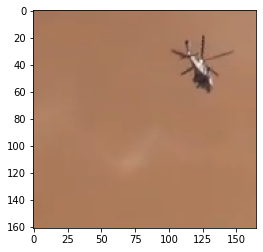

In [21]:
imgCropped = img[102:263,177:342]
plt.imshow(imgCropped)

In [6]:
img2 = cv2.imread("DRONE_000001.png")


In [7]:
img2.shape

(512, 640, 3)

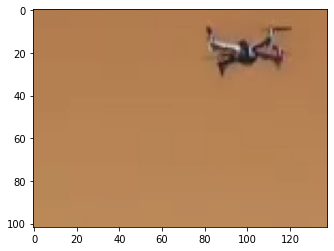

In [8]:
imgCropped = img2[23:125,63:201]
plt.imshow(imgCropped)

In [11]:
imgCropped.shape

(100, 150, 3)